In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/

/content/drive/MyDrive


In [3]:
import os
import matplotlib as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
def set_seeds(seed:int=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [6]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torch.load('Pretrained_ViT_B_16.pth').to(device) #torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
#torch.save(pretrained_vit, "Pretrained_ViT_B_16.pth") # uncomment for model output

In [ ]:
!pip install torchinfo

In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 27]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [7]:
# Load dataset
train_dir = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/'
test_dir = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/'

In [8]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [9]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(train_dir:str, test_dir:str, transform:transforms.Compose, batch_size:int, num_workers:int=NUM_WORKERS):
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    class_names = train_data.classes

    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_dataloader, test_dataloader, class_names

print(class_names)

['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [10]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [11]:
model = pretrained_vit #torch.load('Pretrained_ViT_B_16.pth')
model.load_state_dict(torch.load('vit_model.pth'))
model.to(device)
model.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [13]:
import numpy as np


In [ ]:
# Function to get predictions and true labels
def get_predictions_and_labels(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, labels = get_predictions_and_labels(model, test_dataloader_pretrained)



In [15]:
print(labels)
print(preds)

[ 0  0  0 ... 26 26 26]
[ 0  0  0 ... 26 26 26]


Evaluation Metrics

In [16]:
# Calculate metrics
accuracy = accuracy_score(labels, preds)
precision = precision_score(labels, preds, average='weighted')
recall = recall_score(labels, preds, average='weighted')
f1 = f1_score(labels, preds, average='weighted')

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

Accuracy: 0.9285
Precision: 0.9294
Recall: 0.9285
F1 Score: 0.9285


In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
#from ViTScripts import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

step 1 done


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid don

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Streaming output truncated to the last 5000 lines.
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
step mid done
step 2 done
s

In [ ]:
torch.save(pretrained_vit.state_dict(), 'vit_model.pth')

In [ ]:
"""
A series of helper functions used throughout the course.

If a function gets defined once and could be used over and over, it'll go in here.
"""
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests
import os



# Plot linear data or training and test and predictions (optional)
def plot_predictions(
    train_data, train_labels, test_data, test_labels, predictions=None
):
    """
  Plots linear training data and test data and compares predictions.
  """
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    if predictions is not None:
        # Plot the predictions in red (predictions were made on the test data)
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14})


# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


def print_train_time(start, end, device=None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"\nTrain time on {device}: {total_time:.3f} seconds")
    return total_time


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


# Pred and plot image function from notebook 04
# See creation: https://www.learnpytorch.io/04_pytorch_custom_datasets/#113-putting-custom-image-prediction-together-building-a-function
from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

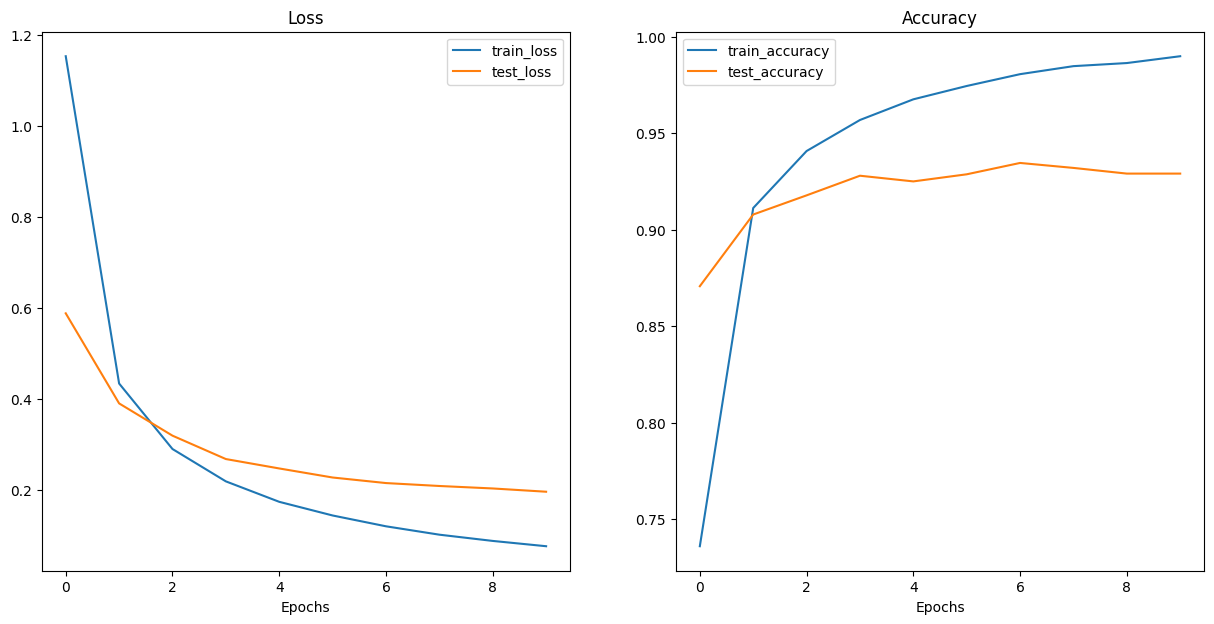

In [ ]:
# Plot the loss curves
#from ViTScripts.helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
"""
Utility functions to make predictions.

Main reference for code creation: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
"""
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

from typing import List, Tuple

from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)


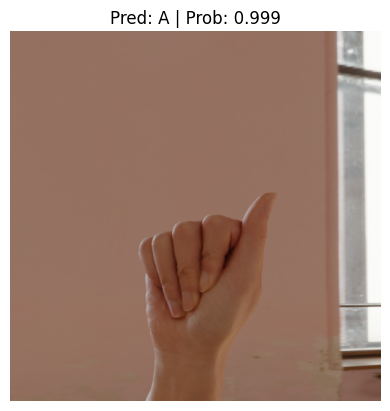

In [ ]:
import requests

# Import function to make predictions on images and plot them
#from ViTScripts.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = '/content/drive/MyDrive/Kaggle3/Train_Alphabet/A/0042513a-63c0-499f-a7f7-e6ee1266cb98.rgb_0000.png'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

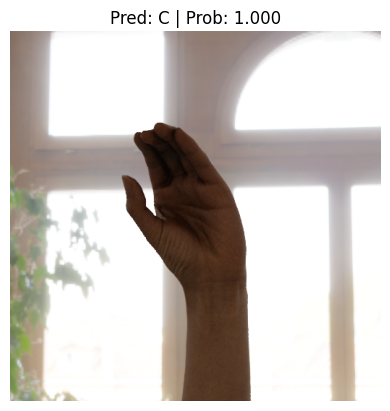

In [ ]:
custom_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/C/17b57e1a-f375-4c76-a2ac-e26c05b89dae.rgb_0000.png'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

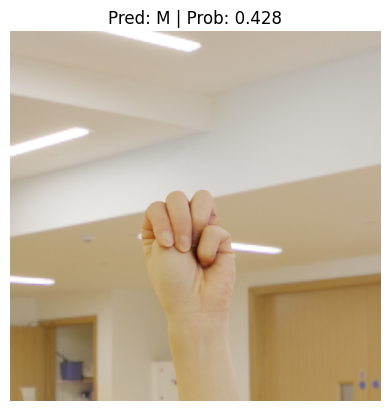

In [ ]:
custom_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/M/187f3eb8-c2e0-4caf-a500-14acc888ea1f.rgb_0000.png'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

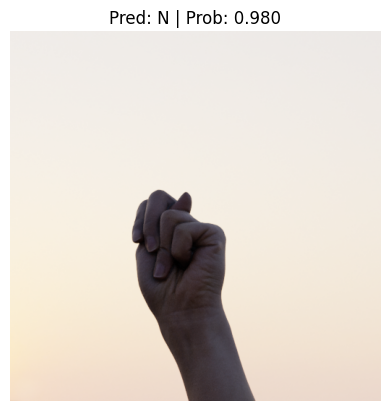

In [ ]:
custom_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
print(pretrained_vit)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

Explainability

1.  Layer-wise Relevance Propagation (LRP)

In [ ]:
!pip install captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from captum.attr import LayerConductance, LayerLRP
from PIL import Image

# Load pre-trained Vision Transformer model
model = torch.load('Pretrained_ViT_B_16.pth')
model.load_state_dict(torch.load('vit_model.pth'))
model.to('cuda')
model.eval()

# Define transforms to preprocess input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess input image
input_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png'  # Provide path to your input image
input_image = Image.open(input_image_path)
input_tensor = transform(input_image).unsqueeze(0).to('cuda')  # Add batch dimension

# Perform inference to get model prediction
with torch.no_grad():
    output = model(input_tensor)

predicted_class = torch.argmax(output).item()
print("Predicted Class:", predicted_class)


Predicted Class: 14


In [ ]:
from captum.attr import IntegratedGradients

# Define Integrated Gradients attribution method
ig = IntegratedGradients(model)

# Perform IG to compute attribute scores
attribution = ig.attribute(input_tensor, target=predicted_class)

# Normalize attribute scores to [0, 1] range
attribution_normalized = attribution / torch.max(torch.abs(attribution))

In [ ]:
print(attribution.shape)

torch.Size([1, 3, 224, 224])


In [ ]:
# from captum.attr import LayerLRP
# from captum.attr._utils.lay import LayerGradientXActivation
# # Define LRP attribution method
# lrp = LayerLRP(model)
# lrp.gradient_func = LayerGradientXActivation(model.encoder.layers)

# # Perform LRP to compute relevance scores
# attribution = lrp.attribute(input_tensor, target=predicted_class)

# # Normalize relevance scores to [0, 1] range
# attribution_normalized1 = attribution / torch.max(torch.abs(attribution))

In [ ]:
import numpy as np

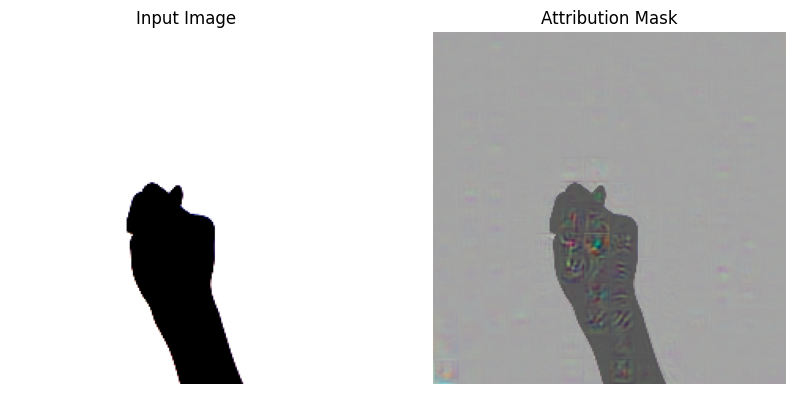

In [ ]:
def visualize_attribution(input_image, attribution):
    # Convert the attribution tensor to numpy array
    attribution_np = attribution.squeeze(0).cpu().detach().numpy()

    # Normalize attribution values between 0 and 1
    attribution_np = (attribution_np - np.min(attribution_np)) / (np.max(attribution_np) - np.min(attribution_np))


    # Plot the input image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy())
    plt.axis('off')
    plt.title('Input Image')

    # Plot the attribution mask
    plt.subplot(1, 2, 2)
    plt.imshow(np.transpose(attribution_np, (1, 2, 0)), cmap='hot', alpha=1, interpolation='bilinear')
    plt.imshow(input_image.squeeze(0).permute(1, 2, 0).cpu().numpy(), alpha=0.3)
    plt.axis('off')
    plt.title('Attribution Mask')

    plt.show()

# Visualize Layer Grad-CAM attribution
visualize_attribution(input_tensor, attribution)

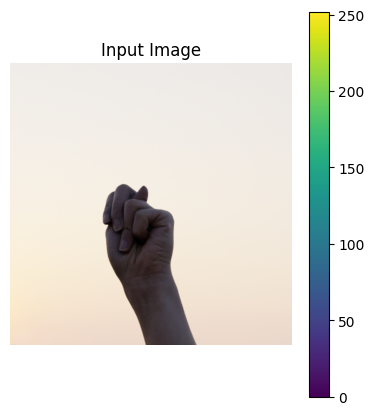

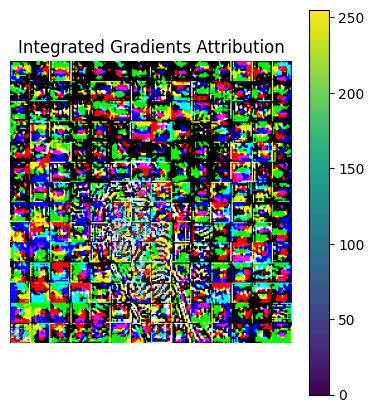

In [ ]:
import matplotlib.pyplot as plt

# Convert attribution tensor to numpy array and squeeze to remove batch dimension
attribution_map = attribution_normalized.squeeze(0).cpu().detach().numpy()

from PIL import Image

input_image = Image.open(input_image_path)

# Convert the attribution map to a PIL image
attribution_image = Image.fromarray((attribution_map * 255).astype('uint8').transpose(1, 2, 0))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.colorbar()
plt.axis('off')
plt.title('Input Image')

# Display the attribution image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(attribution_image)
plt.colorbar()
plt.axis('off')
plt.title('Integrated Gradients Attribution')
plt.show()

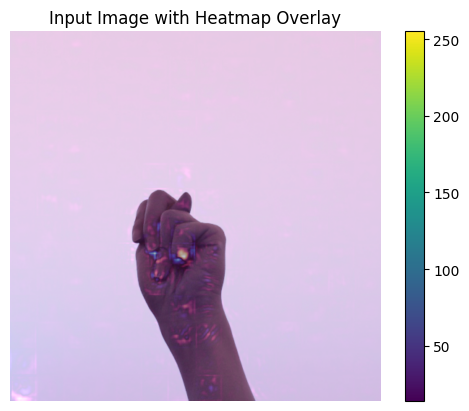

In [ ]:
import cv2

# Convert the PIL Image to a numpy array
input_image_np = np.array(input_image)

# Convert the attribution map to a heatmap with values in [0, 1]
heatmap = attribution_map[0]  # Assuming the first channel represents the attribution
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Resize the heatmap to match the input image size
heatmap_resized = cv2.resize(heatmap, (input_image.size[0], input_image.size[1]))

# Apply colormap to the heatmap
heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_TWILIGHT)

# Blend the heatmap with the input image using alpha blending
blended_image = cv2.addWeighted(cv2.cvtColor(input_image_np, cv2.COLOR_RGB2BGR), 0.8, heatmap_colormap, 0.8, 0)

# Display the blended image
plt.imshow(blended_image, interpolation='bilinear')
plt.colorbar()
plt.axis('off')
plt.title('Input Image with Heatmap Overlay')
plt.show()


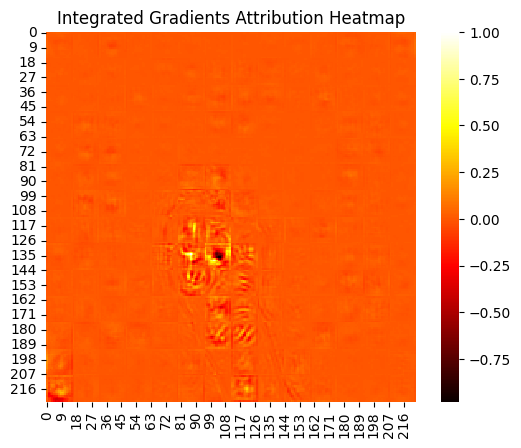

In [ ]:
import seaborn as sns

# Create a heatmap using seaborn
sns.heatmap(attribution_map[0], cmap='hot', square=True)  # Assuming attribution_map[0] represents the relevance scores for the first channel (e.g., R channel)
plt.title('Integrated Gradients Attribution Heatmap')
plt.show()

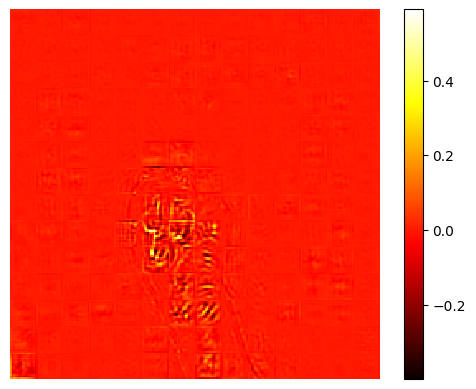

In [ ]:
# Average attributions across color channels
attribution_map_2d = attribution_map.mean(axis=0)

# Visualize the 2D attribution map
plt.imshow(attribution_map_2d, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.axis('off')
plt.show()


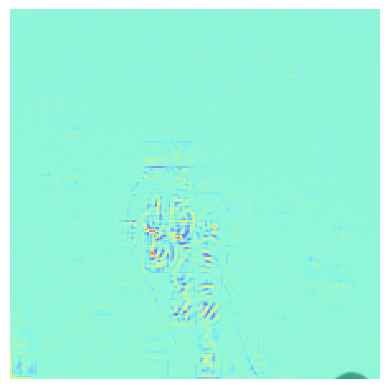

In [ ]:
# Convert PIL image to numpy array
original_image_np = np.array(input_image)

# Normalize original image to [0, 1] range
#original_image_np = original_image_np / 255.0

# Create a new matplotlib figure
plt.figure()

# Display the original image
plt.imshow(original_image_np)

# Overlay the heatmap
# We use the 'jet' colormap here, but you can use 'hot' or any other colormap you like
# The alpha parameter controls the transparency of the heatmap
plt.imshow(attribution_map_2d, cmap='jet', alpha=0.5, interpolation='nearest')

# Hide the axis
plt.axis('off')

# Show the figure
plt.show()

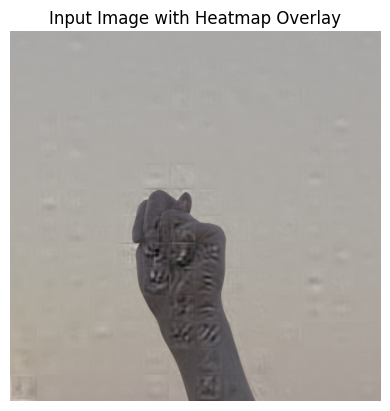

In [ ]:
import numpy as np

# Convert the attribution map to a heatmap with values in [0, 1]
heatmap = attribution_map[1]  # Assuming the first channel represents the attribution
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Resize the heatmap to match the input image size
heatmap_resized = np.uint8(255 * heatmap)  # Convert to uint8 for compatibility with PIL
heatmap_resized = Image.fromarray(heatmap_resized).resize(input_image.size)

# Convert the heatmap to RGB
heatmap_rgb = heatmap_resized.convert('RGB')

# Blend the heatmap with the input image using alpha blending
blended_image = Image.blend(input_image, heatmap_rgb, alpha=0.5)

# Display the blended image
plt.imshow(blended_image)
plt.axis('off')
plt.title('Input Image with Heatmap Overlay')
plt.show()

In [ ]:
from captum.attr import LayerGradCam

# # Define the transformations
# transformer = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# # Load and preprocess the image
# image = Image.open(input_image_path)
# input_img = transformer(image).unsqueeze(0)  # Add batch dimension

# # Ensure the input tensor requires gradients
input_tensor = input_tensor.requires_grad_(True)

# Define GradCAM attribution method
# Here, we use the `blocks` attribute of the model as the target layer
gradcam = LayerGradCam(model, model.encoder)

# Perform GradCAM to compute attribute scores
attribution2 = gradcam.attribute(input_tensor, target=predicted_class)

# Normalize attribute scores to [0, 1] range
attribution_normalized2 = attribution2 / torch.max(torch.abs(attribution2))

In [ ]:
layer_grad_cam = LayerGradCam(model, model.encoder.layers[-1].self_attention)

# Input image tensor (batch size of 1 as we're explaining one instance)
input_image = torch.randn(1, 3, 224, 224)

# Compute attribution
attribution = layer_grad_cam.attribute(input_tensor)

# Print the attribution
print(attribution.shape)

In [ ]:
visualize_attribution(input_tensor, attribution2)

In [ ]:
import numpy as np
import torch
import torchvision.transforms as transforms
#from torchvision import models
#from captum.attr import LayerConductance, LayerLRP
from PIL import Image
import matplotlib.pyplot as plt

from captum.attr import LayerGradCam

In [ ]:
# Load pre-trained Vision Transformer model
model = torch.load('Pretrained_ViT_B_16.pth')
model.load_state_dict(torch.load('vit_model.pth'))
model.to('cuda')
model.eval()

# # Define transforms to preprocess input image
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# Load and preprocess input image
input_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png'  # Provide path to your input image
# input_image = Image.open(input_image_path)
# input_tensor = transform(input_image).unsqueeze(0).to('cuda')

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = input_image_path
image = Image.open(image_path)
input_image = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension


# Print the model architecture to identify the correct layer
#print(model)

input_image.requires_grad_(True)

# Make a prediction to get the predicted class
output = model(input_image)
predicted_class = output.argmax(dim=1).item()
print("Predicted Class:", predicted_class)

Predicted Class: 14


In [ ]:
if isinstance(input_image, torch.Tensor):
    print(input_image.shape)

torch.Size([1, 3, 224, 224])


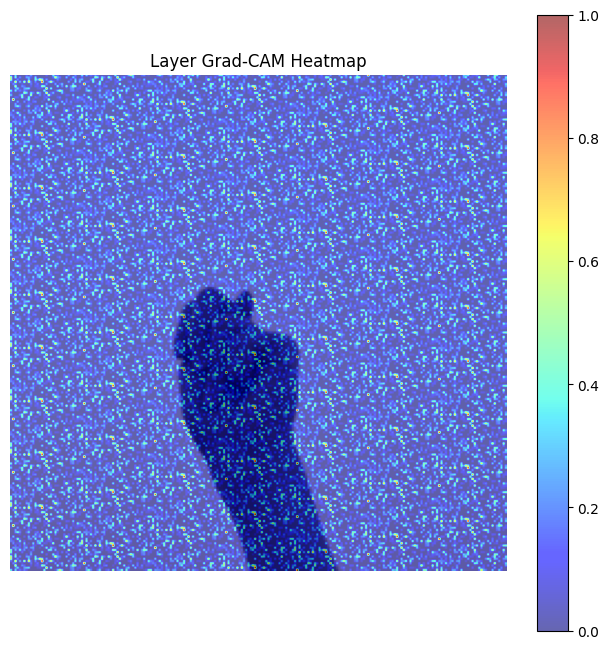

In [ ]:
model.eval()

if not isinstance(input_image, torch.Tensor):
    input_image = torch.tensor(input_image)
# Assuming the last encoder block's self-attention layer is the target layer for Grad-CAM
target_layers = model.encoder.layers[-1].ln_2

# Define the LayerGradCam object
layer_grad_cam = LayerGradCam(model, target_layers)

# Compute the Layer Grad-CAM attributions
attributions = layer_grad_cam.attribute(input_image, target=predicted_class)

# print(f"Shape of attributions before squeezing: {attributions.shape}")
# attributions = attributions.squeeze(0)
# print(f"Shape of attributions after squeezing: {attributions.shape}")


def visualize_heatmap(input_image, attributions):
    # Convert the attributions to numpy array
    attributions_np = attributions.squeeze(0).cpu().detach().numpy()

    # Aggregate the attributions and apply ReLU
    heatmap = np.maximum(attributions_np, 0)

    # Normalize the heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Resize the heatmap to match the input image dimensions
    heatmap = np.mean(heatmap, axis=0)
    heatmap = np.resize(heatmap, (224, 224))

    # Convert input image tensor to numpy for visualization
    input_image_np = input_image.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())

    # Plot the heatmap over the input image
    plt.figure(figsize=(8, 8))
    plt.imshow(input_image_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.colorbar()
    plt.axis('off')
    plt.title('Layer Grad-CAM Heatmap')
    plt.show()

# Visualize the heatmap
visualize_heatmap(input_image, attributions)

In [ ]:
# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = input_image_path
image = Image.open(image_path)
input_image = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension

# Ensure the input tensor requires gradients
input_image.requires_grad_(True)

# Print the model architecture to identify the correct layer
#print(model)

# Assuming the last encoder block's self-attention layer is the target layer for Grad-CAM
target_layers = model.encoder

# Define the LayerGradCam object
layer_grad_cam = LayerGradCam(model, target_layers)

# Make a prediction to get the predicted class
output = model(input_image)
_, predicted_class = torch.max(output, 1)

# Compute the Layer Grad-CAM attributions
attributions = layer_grad_cam.attribute(input_image, target=predicted_class)

print(attributions.shape)

def visualize_heatmap(input_image, attributions):
    # Convert the attributions to numpy array
    attributions_np = np.transpose(attributions.squeeze().cpu().detach().numpy(), (1, 2, 0))

    # Aggregate the attributions and apply ReLU
    heatmap = np.maximum(attributions_np, 0)

    # Normalize the heatmap
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

    # Resize the heatmap to match the input image dimensions
    heatmap = cv2.resize(heatmap, (224, 224))

    # Convert input image tensor to numpy for visualization
    input_image_np = input_image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
    input_image_np = input_image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    input_image_np = np.clip(input_image_np, 0, 1)

    # Plot the heatmap over the input image
    plt.figure(figsize=(8, 8))
    plt.imshow(input_image_np)
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.colorbar()
    plt.axis('off')
    plt.title('Layer Grad-CAM Heatmap')
    plt.show()

# Visualize the heatmap
visualize_heatmap(input_image, attributions)


torch.Size([1, 1, 768])


ValueError: axes don't match array

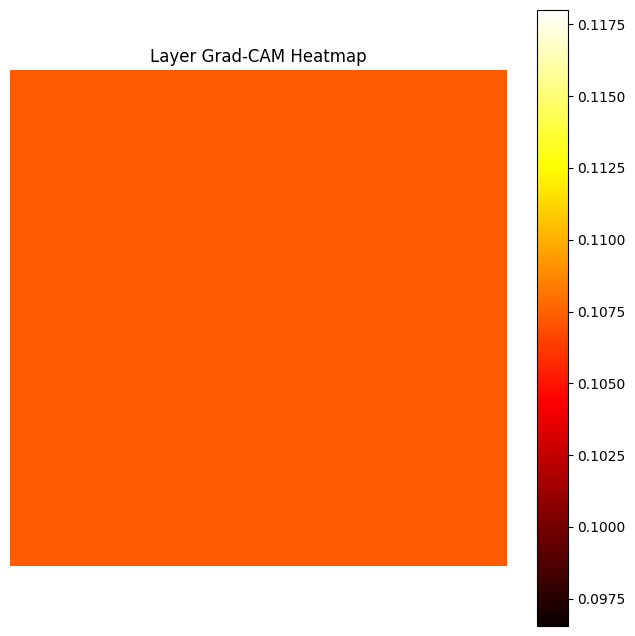

In [ ]:
import matplotlib.pyplot as plt

# Convert attribution tensor to numpy array and squeeze to remove batch dimension
attribution_map2 = attribution_normalized2.squeeze(0).cpu().detach().numpy()

from PIL import Image

# Aggregate the attributions and apply ReLU
heatmap = np.maximum(attribution_map2, 0).mean(axis=0)

# Normalize the heatmap
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

 # Resize the heatmap to match the input image dimensions
heatmap = np.mean(heatmap, axis=0)
heatmap = np.resize(heatmap, (224, 224))

# Plot the heatmap over the input image
plt.figure(figsize=(8, 8))
input_image_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())
#plt.imshow(input_image_np)
plt.imshow(heatmap, cmap='hot', alpha=1)
plt.colorbar()
plt.axis('off')
plt.title('Layer Grad-CAM Heatmap')
plt.show()

# # Convert the attribution map to a PIL image
# attribution_image2 = Image.fromarray((attribution_map2 * 255).astype('uint8').transpose(1, 2, 0))

# # Display the attribution image
# plt.figure(figsize=(10, 5))
# plt.subplot(1, 2, 1)
# plt.imshow(attribution_image2)
# plt.colorbar()
# plt.axis('off')
# plt.title('Layer GradCAM')
# plt.show()

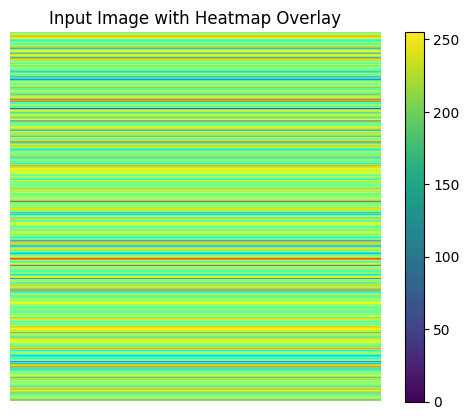

In [ ]:
import cv2

# Convert the PIL Image to a numpy array
input_image_np = np.array(input_image)

# Convert the attribution map to a heatmap with values in [0, 1]
heatmap = attribution_map2[0]  # Assuming the first channel represents the attribution
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Resize the heatmap to match the input image size
heatmap_resized = cv2.resize(heatmap, (input_image.size[0], input_image.size[1]))

# Apply colormap to the heatmap
heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Blend the heatmap with the input image using alpha blending
blended_image = cv2.addWeighted(cv2.cvtColor(input_image_np, cv2.COLOR_RGB2BGR), 0, heatmap_colormap, 1, 0)

# Display the blended image
plt.imshow(blended_image, interpolation='bilinear')
plt.colorbar()
plt.axis('off')
plt.title('Input Image with Heatmap Overlay')
plt.show()

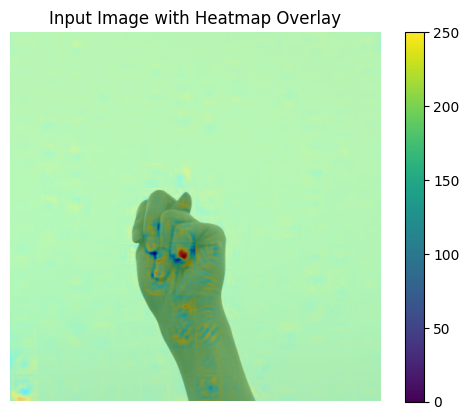

In [ ]:
import cv2

# Convert the PIL Image to a numpy array
input_image_np2 = np.array(input_image)

# Convert the attribution map to a heatmap with values in [0, 1]
heatmap = attribution_map2[0]  # Assuming the first channel represents the attribution
heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))

# Resize the heatmap to match the input image size
heatmap_resized = cv2.resize(heatmap, (input_image.size[0], input_image.size[1]))

# Apply colormap to the heatmap
heatmap_colormap = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Blend the heatmap with the input image using alpha blending
blended_image = cv2.addWeighted(cv2.cvtColor(input_image_np, cv2.COLOR_RGB2BGR), 0.5, heatmap_colormap, 0.5, 0)

# Display the blended image
plt.imshow(blended_image)
plt.colorbar()
plt.axis('off')
plt.title('Input Image with Heatmap Overlay')
plt.show()

In [ ]:
with torch.no_grad():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = preprocess_image('/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png')

        # Make a prediction on image with an extra dimension and send it to the target device
        output = pretrained_vit(transformed_image.to(device))

In [ ]:
target_image_pred_probs = torch.softmax(output, dim=1)

# Convert prediction probabilities -> prediction labels
predicted_class = torch.argmax(target_image_pred_probs, dim=1)
print(f"Predicted class: {predicted_class}")

Predicted class: tensor([14])


In [ ]:
predicted_class1 = output.argmax(dim=1).item()
print(f"Predicted class: {predicted_class}")

Predicted class: tensor([14])


In [ ]:
attributions = lf.linear_epsilon(
    transformed_image.requires_grad_(),
    pretrained_vit.heads[predicted_class].weight,
    pretrained_vit.heads[predicted_class].bias,
)

TypeError: 'Linear' object is not subscriptable

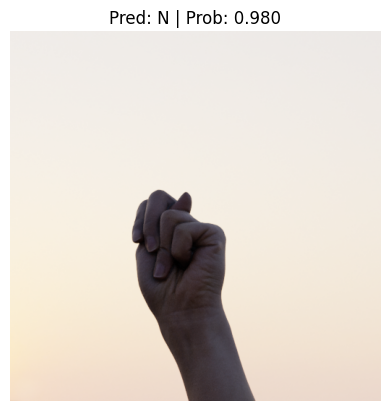

In [ ]:
custom_image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/N/089e9b3e-a837-4426-a543-f0e07f0e1033.rgb_0000.png'

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
#!pip install captum

In [ ]:
# import torch
# import torchvision.transforms as transforms
# from PIL import Image
# from captum.attr import LayerGradCam, visualization

In [ ]:
# import torch
# import torchvision
# import torch.nn as nn

# # 1. Get pretrained weights for ViT-Base
# pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# # 2. Setup a ViT model instance with pretrained weights
# pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# # 3. Freeze the base parameters
# for parameter in pretrained_vit.parameters():
#     parameter.requires_grad = False

# # 4. Change the classifier head
# class_names = ['A', 'B', 'Blank', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

# set_seeds()
# pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names))

# # 5. Load the state dictionary
# state_dict = torch.load('vit_model.pth', map_location=torch.device('cpu'))

# # 6. Load the state_dict into the model
# pretrained_vit.load_state_dict(state_dict)

# # 7. Set the model to evaluation mode
# pretrained_vit.eval()


In [ ]:
# # Load and preprocess the input image
# def preprocess_image(image_path):
#     image = Image.open(image_path).convert('RGB')
#     preprocess = transforms.Compose([
#         transforms.Resize((224, 224)),  # Resize image to fit model input size
#         transforms.ToTensor(),           # Convert image to tensor
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image
#     ])
#     return preprocess(image).unsqueeze(0)  # Add batch dimension

# image_path = '/content/drive/MyDrive/Kaggle3/Test_Alphabet/C/17b57e1a-f375-4c76-a2ac-e26c05b89dae.rgb_0000.png'
# input_image = preprocess_image(image_path)

In [ ]:
from captum.attr import LayerAttribution
module = pretrained_vit.heads

# Compute relevance scores using Layer-wise Relevance Propagation (LRP)
layer_attribution = LayerGradCam(pretrained_vit, module)
attributions = layer_attribution.attribute(input_image)

In [ ]:
# Visualize relevance scores
visualization.visualize_image_attr_multiple(
    torch.mean(attributions, dim=1).squeeze(0).cpu().detach().numpy(),
    original_image=input_image.squeeze(0).cpu().detach().numpy(),
    method='blended_heat_map',
    show_colorbar=True,
    sign='absolute_value',
    cmap='viridis',
    alpha_overlay=0.5
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Function to overlay heatmap on input image
def overlay_heatmap(input_image, heatmap, alpha=0.5, cmap='jet'):
    heatmap = cv2.resize(heatmap, (input_image.shape[1], input_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Combine heatmap with input image
    overlaid_image = cv2.addWeighted(input_image, 1, heatmap, alpha, 0)

    return overlaid_image

In [ ]:
# import torch.nn as nn
# from torchvision.models import VisionTransformer
# from torchvision import transforms

# import torch.nn as nn
# from torchvision.models import VisionTransformer

# import torch.nn as nn
# from torchvision.models import VisionTransformer

# class YourModel(VisionTransformer):
#     def __init__(self, drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0):
#         super(YourModel, self).__init__(
#             image_size=224,  # Change this to match your input image size
#             patch_size=16,
#             num_classes=27,
#             num_layers=12,
#             hidden_dim=768,
#             num_heads=12,
#             mlp_dim=3072
#         )
#         # Replace the above arguments with the specific configuration of your model
#         self.drop_rate = drop_rate
#         self.attn_drop_rate = attn_drop_rate
#         self.drop_path_rate = drop_path_rate

#     def forward(self, x):
#         # Assuming input image size is (B, C, H, W) where B is batch size, C is channels, H is height, and W is width
#         x = self.conv_proj(x)  # Apply convolutional projection
#         x = x.flatten(2).transpose(1, 2)  # Flatten and transpose to match transformer input shape
#         x = self.pos_embed(x)  # Add positional embeddings
#         x = nn.functional.dropout(x, p=self.drop_rate, training=self.training)

#         # Apply the transformer encoder layers
#         for block in self.encoder.layers:
#             x = block(x)

#         x = self.norm(x)
#         x = x.mean(1)  # Aggregate along the sequence dimension
#         x = self.heads(x)  # Final classification heads
#         return x

#     def load_state_dict(self, state_dict, strict=True):
#         new_state_dict = {}
#         for key, value in state_dict.items():
#             if key.startswith('heads.'):
#                 new_key = key.replace('heads.', 'heads.head.')
#                 new_state_dict[new_key] = value
#             else:
#                 new_state_dict[key] = value

#         super(YourModel, self).load_state_dict(new_state_dict, strict=strict)



# # Define hook to capture gradients
# class GradCAM:
#     def __init__(self, model, target_layer):
#         self.model = model
#         self.target_layer = target_layer
#         self.gradients = None

#         self.model.eval()
#         self.register_hooks()

#     def register_hooks(self):
#         def hook_fn(module, input, output):
#             self.gradients = torch.autograd.grad(outputs=output, inputs=input[0], grad_outputs=torch.ones_like(output), retain_graph=True, create_graph=True)[0]

#         self.target_layer.register_forward_hook(hook_fn)

#     def forward(self, x):
#         return self.model(x)

#     def backward(self, pred_index):
#         one_hot_output = torch.zeros_like(pred_index).scatter(1, pred_index, 1)
#         self.model.zero_grad()
#         self.gradients.backward(gradient=one_hot_output, retain_graph=True)

#     def generate(self, input_image, pred_index):
#         output = self.forward(input_image)
#         self.backward(pred_index)

#         gradients = torch.mean(self.gradients, dim=(2, 3), keepdim=True)
#         activations = self.target_layer.output

#         grad_cam = torch.mean(gradients * activations, dim=1).squeeze().detach().cpu().numpy()
#         grad_cam = np.maximum(grad_cam, 0)  # ReLU operation
#         grad_cam /= np.max(grad_cam)  # Normalize

#         return grad_cam



# # Load your model
# pretrained_vit = YourModel()
# pretrained_vit.load_state_dict(torch.load('vit_model.pth'))

# # Choose the target layer (e.g., encoder_layer_11)
# target_layer = pretrained_vit.encoder.layers[-1]  # Use the last encoder layer

# # Initialize GradCAM
# gradcam = GradCAM(pretrained_vit, target_layer)

# def generate_cam(input_image):
#       image_transform = transforms.Compose(
#           [
#               transforms.Resize((224,224)),
#               transforms.ToTensor(),
#               transforms.Normalize(
#                   mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
#               ),
#           ]
#       )

#       # Generate Grad-CAM heatmap for a specific class (e.g., the predicted class)
#       img = Image.open(input_image)  # Provide your input image here
#       img_tensor = image_transform(img).unsqueeze(0)
#       output = pretrained_vit(img_tensor)
#       pred_index = torch.argmax(output, dim=1)

#       heatmap = gradcam.generate(img_tensor, pred_index)

#       overlaid_image = overlay_heatmap(img, heatmap)

#       # Visualize input image and overlaid heatmap
#       fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#       ax[0].imshow(input_image)
#       ax[0].set_title('Input Image')
#       ax[0].axis('off')

#       ax[1].imshow(overlaid_image)
#       ax[1].set_title('Grad-CAM Heatmap')
#       ax[1].axis('off')

#       plt.show()

#       # Now, we can visualize the Grad-CAM heatmap overlaid on the input image to interpret model predictions


In [ ]:
!pip install grad-cam

In [ ]:
from pytorch_grad_cam import GradCAM

target_layers = model.encoder.layers[-1].self_attention

def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)  # Bring channels to the first dimension
    return result

cam = GradCAM(model=model, target_layers=[target_layers], reshape_transform=reshape_transform)

In [ ]:
map = cam(input_tensor=torch.randn(1, 3, 224, 224), targets=None)

TypeError: tuple indices must be integers or slices, not tuple

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_i[ ]
!pip install timm
￼
￼
Collecting timm
  Downloading timm-1.0.3-py3-none-any.whl (2.3 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.2 MB/s eta 0:00:00
Requirement already satisfied: torch in /usr/local/lib/python3.10/dist-packages (from timm) (2.2.1+cu121)
Requirement almage, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the image
image_path = input_image_path
image = Image.open(image_path)
input_tensor1 = transform(image).unsqueeze(0).to('cuda')  # Add batch dimension

# Ensure the input tensor requires gradients
input_tensor1.requires_grad = True

# Make a prediction to get the predicted class
output = model(input_tensor1)
predicted_class = output.argmax(dim=1).item()

# Define the target layer (e.g., the last encoder block's self_attention)
target_layers = [model.encoder.layers[-1].self_attention]

# Define the reshape transform function
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1:, :].reshape(tensor.size(0), height, width, tensor.size(2))
    result = result.permute(0, 3, 1, 2)  # Bring channels to the first dimension
    return result

# Initialize Grad-CAM
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

# Generate the Grad-CAM heatmap
targets = [ClassifierOutputTarget(predicted_class)]
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]  # [0] to get the first (and only) batch

# Visualize the heatmap on the input image
# Convert input image tensor to numpy for visualization
input_image_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())

# Generate the heatmap overlay
heatmap = show_cam_on_image(input_image_np, grayscale_cam, use_rgb=True)

# Plot the heatmap
plt.figure(figsize=(8, 8))
plt.imshow(heatmap)
plt.axis('off')
plt.title('Grad-CAM Heatmap')
plt.show()


TypeError: tuple indices must be integers or slices, not tuple